In [291]:
import numpy as np
import scipy.sparse as sp
import scipy.sparse.linalg as spla
import time
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import scipy
from scipy.sparse import coo_matrix, block_diag



In [292]:
%matplotlib inline

# Problem 1

Complete the function `poisson_square` by implementing the finite difference method given in the lab. Use `scipy.sparse.linalg.spsolve` to solve the linear system. Use your function to solve the boundary value problem:

\begin{align}
	\begin{split}
	\Delta u = 0, &{}\quad x \in [0,1]\times [0,1],\\
	u(x,y) = x^3, &{}\quad (x,y) \in \partial ([0,1]\times [0,1]).
	\end{split}
	\label{poisson2d:laplace}
\end{align}

Use $n=100$ subintervals for both $x$ and $y$. Plot the solution as a 3D surface.

In [293]:
def poisson_square(a,b,c,d,f,g,n):
    """Computes the finite difference method for the Poisson equation boundary-value
    problem on a square:
        
        u_xx + u_yy = f on R = [a,b]×[c,d]
        u = g on ∂R
    
    where (b-a) = (d-c).
        
    Parameters:
        a (float): left-hand boundary for x
        b (float): right-hand boundary for x
        c (float): lower boundary for y
        d (float): uppder boundary for y
        f (function): right-hand side of the PDE
        g (function): boundary condition
        n (int): number of subintervals
    Returns:
        U (ndarray of shape (n+1,n+1)): approximate solution
    """
    #getting x and h
    x,h = np.linspace(a,b,n+1,retstep = True)
    y = np.linspace(c,d,n+1)
    
    #getting I and T to construct A
    I = scipy.sparse.diags([1,1],[-n+1,n-1], shape = ((n-1)**2,(n-1)**2)).toarray()
    T = scipy.sparse.diags([1,-4,1],[-1,0,1], shape = (n-1,n-1)).toarray()
    A = ((block_diag([T]*(n-1)).toarray()) + I)/(h**2)

    #getting p
    p = []
    for j in range(1,n):
        p += [g(x[0],y[j])]+[0]*(n-3)+[g(x[n],y[j])]
        
    p /= (h**2)

    #getting q
    q_1 = [g(x[i], y[0]) for i in range(1, n)]/(h**2)
    q_n_1 = [g(x[i], y[n]) for i in range(1, n)]/(h**2)
    q_j = []
    for i in range(n-3):
        q_j += [0]*(n-1)
    q = np.concatenate((q_1,q_j, q_n_1),axis =None)
        
    #getting f
    f_array = np.ones((n-1,n-1))
    for j in range(n-1):
        for i in range(n-1):
            f_array[j,i] = f(x[i],y[j])
    f_array = f_array.flatten()

    U = spla.spsolve(A, f_array - p-q)
    return U

[2.31797350e-04 4.69529038e-04 7.19129336e-04 ... 9.16148994e-01
 9.43730159e-01 9.71718046e-01]


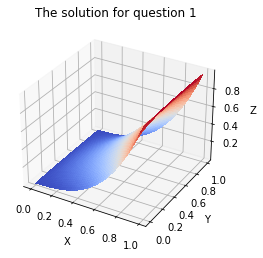

In [294]:
f = lambda x,y: x*0+y*0
g = lambda x,y: x**3+y*0
U = poisson_square(0,1,0,1,f,g,100)
print(U)

#plotting
fig = plt.figure()
ax = fig.add_subplot(111, projection = '3d')
X = np.arange(0,1,1/99)
Y = np.arange(0,1,1/99)
Z = U.reshape(99,99)
X,Y = np.meshgrid(X,Y)

surface = ax.plot_surface(X,Y,Z,cmap = "coolwarm", linewidth = 0, antialiased = False)
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
plt.title("The solution for question 1")
plt.show()

# Problem 2

Solve 

\begin{align}
	\begin{split}
	\Delta V = -\rho(x,y), &{}\quad x \in [-2,2]\times [-2,2],\\
	u(x,y) = 0, &{}\quad (x,y) \in \partial ([-2,2]\times [-2,2]).
	\end{split}
	\label{poisson2d:source}
\end{align}

for the electric potential $V.$ Use the source function defined above, such that $\rho(x,y) = \text{source}(x,y)$. Use $n=100$ subintervals for $x$ and $y$. Use the provided code to plot your solution.

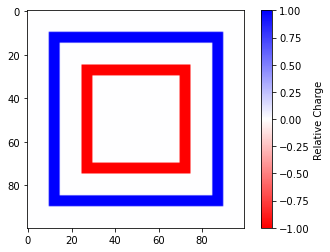

In [295]:
import matplotlib.colors as mcolors

def source(X,Y):
    """
    Takes arbitrary arrays of coordinates X and Y and returns an array of the same shape
    representing the charge density of nested charged squares
    """
    src = np.zeros(X.shape)
    src[ np.logical_or(np.logical_and( np.logical_or(abs(X-1.5) < .1,abs(X+1.5) < .1) ,abs(Y) <  1.6),
    np.logical_and( np.logical_or(abs(Y-1.5) < .1,abs(Y+1.5) < .1) ,abs(X) <  1.6))] = 1
    
    src[ np.logical_or(np.logical_and( np.logical_or(abs(X-0.9) < .1,abs(X+0.9) < .1) ,abs(Y) <  1.0),
    np.logical_and( np.logical_or(abs(Y-0.9) < .1,abs(Y+0.9) < .1) ,abs(X) <  1.0))] = -1
    return src
    
#Generate a color dictionary for use with LinearSegmentedColormap
#that places red and blue at the min and max values of data
#and white when data is zero
def genDict(data):
    zero = 1/(1 - np.max(data)/np.min(data))
    cdict = {
    'red': [(0.0, 1.0, 1.0),(zero, 1.0, 1.0),(1.0, 0.0, 0.0)],
    'green': [(0.0, 0.0, 0.0),(zero, 1.0, 1.0),(1.0, 0.0, 0.0)],
    'blue': [(0.0, 0.0, 0.0),(zero, 1.0, 1.0),(1.0, 1.0, 1.0)]
    }
    return cdict

a1 = -2.
b1 = 2.
c1 = -2.
d1 = 2.
n =100
X = np.linspace(a1,b1,n)
Y = np.linspace(c1,d1,n)
X,Y = np.meshgrid(X,Y)

plt.imshow(source(X,Y),cmap = mcolors.LinearSegmentedColormap('cmap', genDict(source(X,Y))))
plt.colorbar(label="Relative Charge")
plt.show()

[0.00011219 0.00022438 0.00033651 ... 0.00044743 0.00029837 0.00014919]


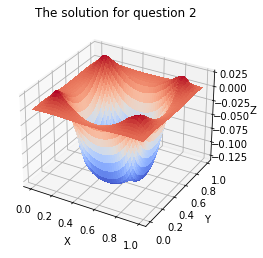

In [296]:
f = lambda x,y: -source(x,y)
g = lambda x,y: x*0+y*0
U = poisson_square(-2,2,-2,2,f,g,100)
print(U)

#plotting
fig = plt.figure()
ax = fig.add_subplot(111, projection = '3d')
X = np.arange(0,1,1/99)
Y = np.arange(0,1,1/99)
Z = U.reshape(99,99)
X,Y = np.meshgrid(X,Y)

surface = ax.plot_surface(X,Y,Z,cmap = "coolwarm", linewidth = 0, antialiased = False)
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
plt.title("The solution for question 2")
plt.show()

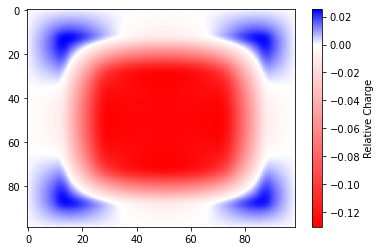

In [297]:
#
plt.imshow(Z, aspect = 'auto', cmap = mcolors.LinearSegmentedColormap('cmap', genDict(Z)))
plt.colorbar(label='Relative Charge')
plt.show()